# STX ML
To install:
```
mkvirtualenv venv-ml
workon venv-ml
pip install -r requirements_new.txt
```
Based on code from https://github.com/Kulbear/stock-prediction

In [42]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import stxcal 
from stxts import StxTS 

## Import data
Load a list of stocks; adjust each stock for splits

In [43]:
stk_list = ['MSFT', 'AMZN', 'AAPL', 'CSCO', 'GE', 'XOM', 'JPM', 'AMAT', 'MGM', 'F','X']
sd = '1960-01-01'
ed = stxcal.current_date()
stk_data = []
for stk in stk_list:
    ts = StxTS(stk, sd, ed)
    dt = str(ts.df.index[ts.l - 1].date())
    ts.set_day(dt)
    ts.df['open_interest'] = ts.df['c'] * ts.df['volume']
    ts.df = ts.df[['o', 'hi', 'lo', 'volume', 'open_interest', 'c']]
    stk_data.append(ts)
    print('Loaded {0:s}'.format(stk))

Loaded MSFT
Loaded AMZN
Loaded AAPL
Loaded CSCO
Loaded GE
Loaded XOM
Loaded JPM
Loaded AMAT
Loaded MGM
Loaded F
Loaded X


In [44]:
ts = stk_data[-1]
ts.df.head()

,o,hi,lo,volume,open_interest,c
1991-04-12,20.00,23.50,20.00,482,10965.50,22.75
1991-04-15,23.13,26.13,23.13,392,10192.00,26.00
1991-04-16,26.00,26.38,25.00,384,9649.92,25.13
1991-04-17,25.50,26.25,25.50,205,5278.75,25.75
1991-04-18,25.75,27.38,25.75,214,5698.82,26.63


Normalize the data prior to feeding into model

In [45]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    return X_train, X_test, preprocessor

Split the data intoX_train, y_train, X_test, y_test

In [48]:
def preprocess_data(stk_data, seq_len):
    amount_of_features = 6 # len(stock.columns)
    sequence_length = seq_len + 1
    first_test_date = '2018-02-01'
    X_train = None
    y_train = None
    X_test = None
    y_test = None
    for stock in stk_data:
        data = stock.df.values
        result = []
        for index in range(len(data) - seq_len):
            result.append(data[index : index + sequence_length])
        row = stock.find(first_test_date) - seq_len
        print('row={0:s}'.format(str(row)))
        result = np.array(result)
        train = result[: row, :]
        train, result, preprocessor = standard_scaler(train, result)
        print("train", train.shape)
        print("result", result.shape)
        print("train[:, : -1]", train[:, : -1].shape)
    
        X_train = train[:, : -1] if X_train is None else np.append(X_train, train[:, :-1], axis=0)
        y_train = train[:, -1][: ,-1] if y_train is None else np.append(y_train, train[:, -1][: ,-1])
        X_test = result[row :, : -1] if X_test is None else np.append(X_test, result[row :, : -1], axis=0)
        y_test = result[row :, -1][ : ,-1] if y_test is None else np.append(y_test, result[int(row) :, -1][ : ,-1])
        print('Done preprocessing {0:s}'.format(stock.stk))
        print("X_train", X_train.shape)
        print("y_train", y_train.shape)
        print("X_test", X_test.shape)
        print("y_test", y_test.shape)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test, preprocessor]

## Build the LSTM Network

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Connected(Dense)

In [49]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.35))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [51]:
window = 20
X_train, y_train, X_test, y_test, preprocessor = preprocess_data(stk_data, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

row=8019
('train', (8019, 21, 6))
('result', (8266, 21, 6))
('train[:, : -1]', (8019, 20, 6))
Done preprocessing MSFT
('X_train', (8019, 20, 6))
('y_train', (8019,))
('X_test', (247, 20, 6))
('y_test', (247,))
row=5193
('train', (5193, 21, 6))
('result', (5440, 21, 6))
('train[:, : -1]', (5193, 20, 6))
Done preprocessing AMZN
('X_train', (13212, 20, 6))
('y_train', (13212,))
('X_test', (494, 20, 6))
('y_test', (494,))
row=8320
('train', (8320, 21, 6))
('result', (8567, 21, 6))
('train[:, : -1]', (8320, 20, 6))
Done preprocessing AAPL
('X_train', (21532, 20, 6))
('y_train', (21532,))
('X_test', (741, 20, 6))
('y_test', (741,))
row=7024
('train', (7024, 21, 6))
('result', (7271, 21, 6))
('train[:, : -1]', (7024, 20, 6))
Done preprocessing CSCO
('X_train', (28556, 20, 6))
('y_train', (28556,))
('X_test', (988, 20, 6))
('y_test', (988,))
row=8320
('train', (8320, 21, 6))
('result', (8567, 21, 6))
('train[:, : -1]', (8320, 20, 6))
Done preprocessing GE
('X_train', (36876, 20, 6))
('y_train'

In [52]:
model = build_model([X_train.shape[2], window, 700, 1])

/home/cma/.envs/venv-ml/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/home/cma/.envs/venv-ml/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=True, input_shape=(None, 6))`
  


('Compilation Time : ', 0.016759157180786133)


/home/cma/.envs/venv-ml/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


## Training the Network

In [53]:
model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=50,
    validation_split=0.1,
    verbose=1)

Train on 75932 samples, validate on 8437 samples
Epoch 1/50
75932/75932 [==============================] - 309s 4ms/step - loss: 0.1494 - acc: 0.0000e+00 - val_loss: 0.0858 - val_acc: 0.0000e+00
Epoch 2/50
75932/75932 [==============================] - 326s 4ms/step - loss: 0.0522 - acc: 0.0000e+00 - val_loss: 0.0474 - val_acc: 0.0000e+00
Epoch 3/50
75932/75932 [==============================] - 321s 4ms/step - loss: 0.0367 - acc: 0.0000e+00 - val_loss: 0.0261 - val_acc: 0.0000e+00
Epoch 4/50
75932/75932 [==============================] - 320s 4ms/step - loss: 0.0318 - acc: 0.0000e+00 - val_loss: 0.0318 - val_acc: 0.0000e+00
Epoch 5/50
75932/75932 [==============================] - 320s 4ms/step - loss: 0.0288 - acc: 0.0000e+00 - val_loss: 0.0313 - val_acc: 0.0000e+00
Epoch 6/50
75932/75932 [==============================] - 321s 4ms/step - loss: 0.0253 - acc: 0.0000e+00 - val_loss: 0.0380 - val_acc: 0.0000e+00
Epoch 7/50
75932/75932 [==============================] - 321s 4ms/step - l

In [54]:
trainScore = model.evaluate(X_train, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=1)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

84369/84369 [==============================] - 228s 3ms/step
Train Score: 0.01 MSE (0.09 RMSE)
2717/2717 [==============================] - 7s 3ms/step
Test Score: 0.31 MSE (0.56 RMSE)


In [55]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

In [57]:
# TODO: Scale it back
import matplotlib
import matplotlib.pyplot as plt2

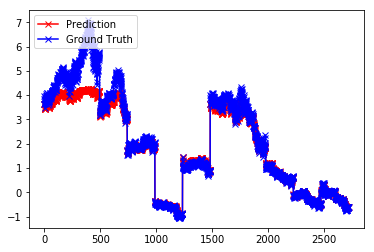

In [63]:
# if using within a jupyter notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', marker='x', label='Prediction')
plt2.plot(y_test, color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

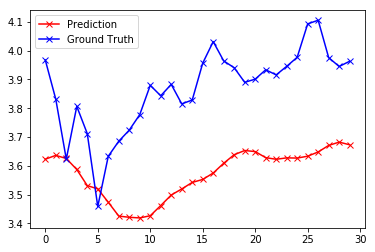

In [58]:
plt2.plot(pred[0:30], color='red', marker='x', label='Prediction')
plt2.plot(y_test[0:30], color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

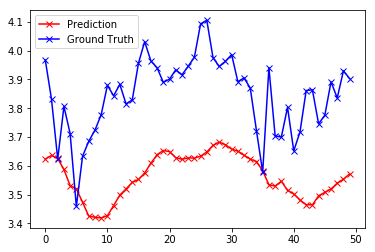

In [59]:
plt2.plot(pred[:50], color='red', marker='x', label='Prediction')
plt2.plot(y_test[:50], color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

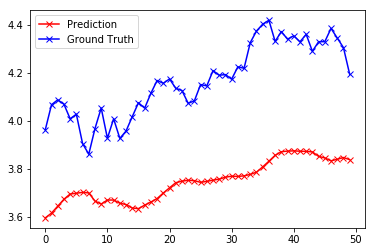

In [60]:
plt2.plot(pred[50:100], color='red', marker='x', label='Prediction')
plt2.plot(y_test[50:100], color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

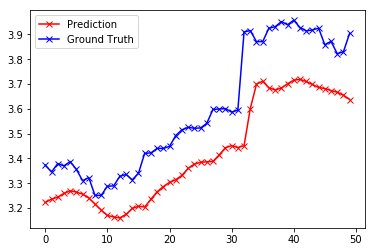

In [62]:
plt2.plot(pred[100:150], color='red', marker='x', label='Prediction')
plt2.plot(y_test[100:150], color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

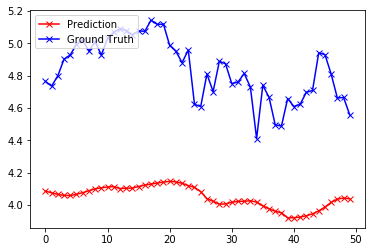

In [61]:
plt2.plot(pred[150:200], color='red', marker='x', label='Prediction')
plt2.plot(y_test[150:200], color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

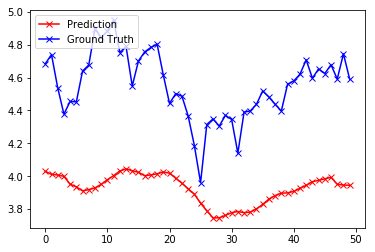

In [62]:
plt2.plot(pred[200:250], color='red', marker='x', label='Prediction')
plt2.plot(y_test[200:250], color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')

plt2.show()